In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstcam_simulation import Camera
from sstcam_simulation.plotting import CameraImage
camera = Camera()
n_pixels = camera.mapping.n_pixels

# Tutorial 2: Simulating Photoelectron Sources

In sstcam-simulation, the simulation of the illumination source and the photosensor's response to it are coupled in the same methods, accounting for all the statistical fluctuations involved in photon counting. These methods are provided in the `PhotoelectronSource` class.

The output of the photoelectron sources are a `Photoelectrons` object, which is a container for three one-dimensional arrays, containing information about the detected photoelectrons in this simulated event. Each entry in these arrays corresponds to one photoelectron.
* `pixel`: the pixel the photoelectron is detected it
* `time`: the time at which the photoelectron arrives in the photosensor
* `charge`: the charge reported by the photosensor for this photoelectron (resulting from the SPE spectrum)

This notebook demonstrates the different methods available in the `PhotoelectronSource` class.

In [3]:
from sstcam_simulation.event.source import PhotoelectronSource
source = PhotoelectronSource(camera=camera, seed=1)
PhotoelectronSource?

Init signature: PhotoelectronSource(camera, seed=None)
Docstring:      <no docstring>
Init docstring:
Collection of methods which simulate illumination sources and the
detection of the photons by the photosensors.

Each method returns a :class:`Photoelectrons` object, which is a
container of 1D arrays describing the pixel, arrival time, and
reported charge of each photoelectron.

Parameters
----------
camera : Camera
    Description of the camera
seed : int or tuple
    Seed for the numpy random number generator.
    Ensures the reproducibility of an event if you know its seed
File:           ~/Software/sstcam-simulation/sstcam_simulation/event/source.py
Type:           type
Subclasses:     


## Night Sky Background (NSB)

This photoelectron source simulates the random arrival of NSB photons, and takes the rate (in MHz) as an input.

In [4]:
source.get_nsb?

Signature: source.get_nsb(rate)
Docstring:
Obtain the photoelectron arrays for random Night-Sky Background light

Parameters
----------
rate : float
    NSB rate in MHz (number of photoelectrons per microsecond)
    This is the rate after already accounting for Photon Detection Efficiency

Returns
-------
Photoelectrons
    Container for the NSB photoelectron arrays
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/source.py
Type:      method


In [5]:
photoelectrons = source.get_nsb(rate=10)
print("Total number of photoelectrons in event: ", len(photoelectrons))

Total number of photoelectrons in event:  20545


Continuous readout duration =  1000


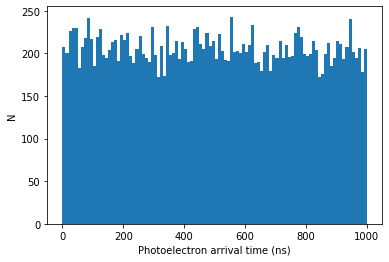

In [6]:
plt.hist(photoelectrons.time, bins=100)
plt.xlabel("Photoelectron arrival time (ns)")
_ = plt.ylabel("N")
# Uniform distribution of arrival times, readout duration defined by:
print("Continuous readout duration = ", camera.continuous_readout_duration)

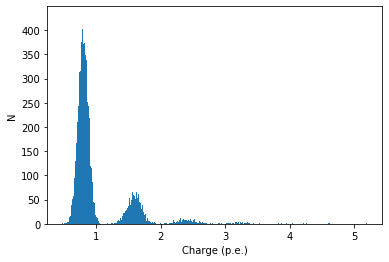

In [7]:
plt.hist(photoelectrons.charge, bins=1000)
plt.xlabel("Charge (p.e.)")
_ = plt.ylabel("N")
# Charge histogram reproduces SPE spectrum

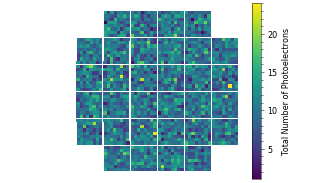

In [8]:
image = CameraImage.from_coordinates(camera.mapping.pixel)
image.image = photoelectrons.get_photoelectrons_per_pixel(n_pixels=n_pixels)
image.add_colorbar("Total Number of Photoelectrons")

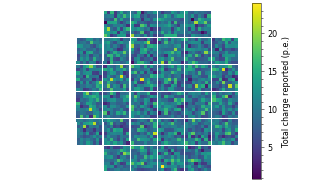

In [9]:
image = CameraImage.from_coordinates(camera.mapping.pixel)
image.image = photoelectrons.get_charge_per_pixel(n_pixels=n_pixels)
image.add_colorbar("Total charge reported (p.e.)")

The difference between these two images is that the first (total number of photoelectrons) is the integer number of photoelectrons that were generated in each pixel during the duration. Whereas the second (total charge reported) is the sum of the reported charges from the pixels, i.e. post SPE spectrum sampling for each photoelectron.

## Uniform Illumination

This photoelectron source simulates a uniform illumination source with a configurable intensity, similar to illuminating the camera with a laser in the lab. However, the illumination behaves as if the camera curviture is already accounted for, and the illumination measured is perfectly uniform (before poisson and SPE spectrum effects).

In [10]:
source.get_uniform_illumination?

Signature: source.get_uniform_illumination(time, illumination, laser_pulse_width=0)
Docstring:
Simulate the camera being illuminated by a uniform light (which already
accounts for the focal plane curvature).

Parameters
----------
time : float
    Arrival time of the light at the focal plane
illumination : float
    Average illumination in number of photoelectrons
laser_pulse_width : float
    Width of the pulse from the illumination source

Returns
-------
Photoelectrons
    Container for the photoelectron arrays
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/source.py
Type:      method


In [11]:
photoelectrons = source.get_uniform_illumination(time=400, illumination=100)
print("Total number of photoelectrons in event: ", len(photoelectrons))

Total number of photoelectrons in event:  204808


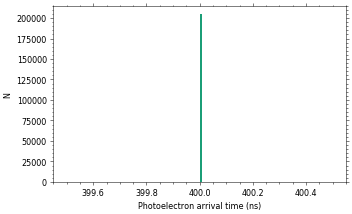

In [12]:
plt.hist(photoelectrons.time, bins=100)
plt.xlabel("Photoelectron arrival time (ns)")
_ = plt.ylabel("N")
# All photoelectrons arrive at same time

In [13]:
photoelectrons = source.get_uniform_illumination(time=400, illumination=100, laser_pulse_width=2)

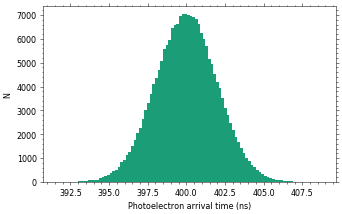

In [14]:
plt.hist(photoelectrons.time, bins=100)
plt.xlabel("Photoelectron arrival time (ns)")
_ = plt.ylabel("N")
# Photoelectrons arrive with a spread according to the illumination pulse width

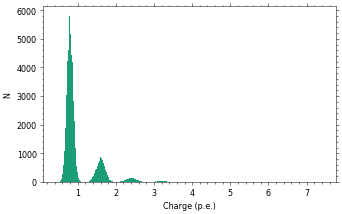

In [15]:
plt.hist(photoelectrons.charge, bins=1000)
plt.xlabel("Charge (p.e.)")
_ = plt.ylabel("N")
# Charge histogram reproduces SPE spectrum, as each entry in the array is still a single photoelectron

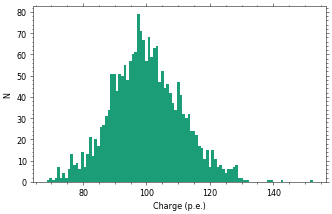

In [16]:
charge_per_pixel = photoelectrons.get_charge_per_pixel(n_pixels=n_pixels)
plt.hist(charge_per_pixel, bins=100)
plt.xlabel("Charge (p.e.)")
_ = plt.ylabel("N")
# Sum of charge produced in each pixel is centered on 100 p.e.

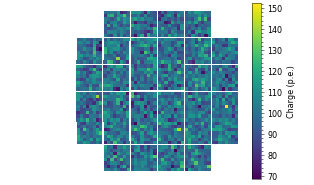

In [17]:
image = CameraImage.from_coordinates(camera.mapping.pixel)
image.image = charge_per_pixel
image.add_colorbar("Charge (p.e.)")

## Cherenkov Shower Ellipse

A toymodel of the illumination from a Cherenkov shower can be simulated through specifying the ellipse and timing properties.

In [18]:
source.get_cherenkov_shower?

Signature:
source.get_cherenkov_shower(
    centroid_x,
    centroid_y,
    length,
    width,
    psi,
    time_gradient,
    time_intercept,
    intensity,
    cherenkov_pulse_width=3,
)
Docstring:
Simulate a Cherenkov shower image

Parameters
----------
centroid_x : float
    X coordinate for the center of the ellipse. Unit: m
centroid_y : float
    Y coordinate for the center of the ellipse. Unit: m
length : float
    Length of the ellipse. Unit: m
width : float
    Width of the ellipse. Unit: m
psi : float
    Rotation of the ellipse major axis from the X axis. Unit: degrees
time_gradient : float
    Rate at which the time changes with distance along the shower axis
    Unit: ns / m
time_intercept : float
    Pulse time at the shower centroid. Unit: ns
intensity : float
    Average total number of photoelectrons contained in shower image
cherenkov_pulse_width : float
    Width of Cherenkov pulse in a single pixel. Unit: ns

Returns
-------
Photoelectrons
    Container for the phot

In [19]:
photoelectrons = source.get_cherenkov_shower(
    centroid_x=0.02,
    centroid_y=0.02,
    length=0.04,
    width=0.01,
    psi=40,
    time_gradient=200,
    time_intercept=400,
    intensity=10000,
    cherenkov_pulse_width=3,
)
print("Total number of photoelectrons in event: ", len(photoelectrons))

Total number of photoelectrons in event:  10090


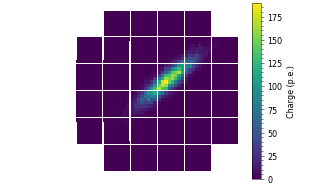

In [20]:
image = CameraImage.from_coordinates(camera.mapping.pixel)
image.image = photoelectrons.get_charge_per_pixel(n_pixels=n_pixels)
image.add_colorbar("Charge (p.e.)")

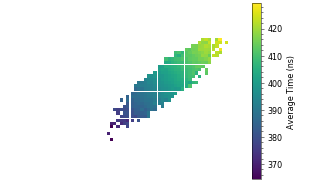

In [21]:
image = CameraImage.from_coordinates(camera.mapping.pixel)
image.image = photoelectrons.get_average_time_per_pixel(n_pixels=n_pixels)
image.add_colorbar("Average Time (ns)")

# Random Cherenkov Shower

It is also possible to obtain a random Cherenkov shower, where the ellipse and timing parameters are extracted from uniform distributions.

In [22]:
source.get_random_cherenkov_shower?

Signature: source.get_random_cherenkov_shower(cherenkov_pulse_width=3)
Docstring:
Simulate a random Cherenkov shower image

Parameters
----------
cherenkov_pulse_width : float
    Width of Cherenkov pulse in a single pixel. Unit: ns

Returns
-------
Photoelectrons
    Container for the photoelectron arrays
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/source.py
Type:      method


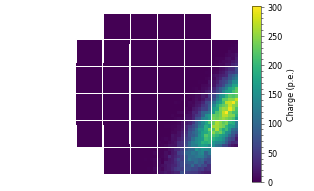

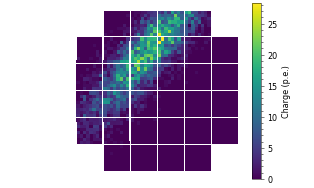

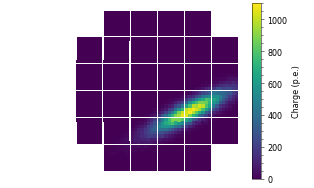

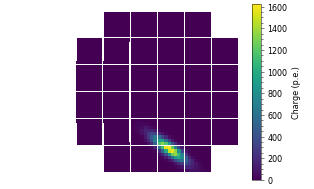

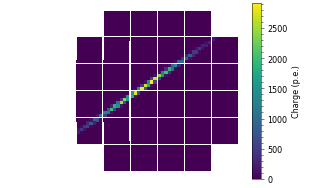

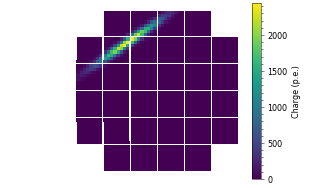

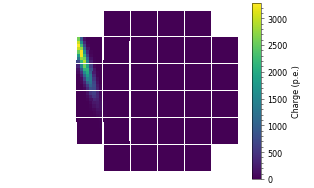

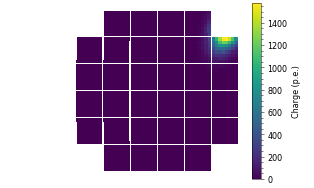

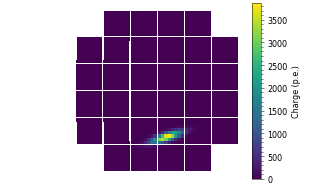

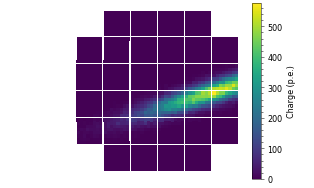

In [23]:
source = PhotoelectronSource(camera=camera)
for i in range(10):
    photoelectrons = source.get_random_cherenkov_shower(cherenkov_pulse_width=3)
    image = CameraImage.from_coordinates(camera.mapping.pixel)
    image.image = photoelectrons.get_charge_per_pixel(n_pixels=n_pixels)
    image.add_colorbar("Charge (p.e.)")